In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import pickle as pkl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import DistilBertModel , DistilBertTokenizer
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [41]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


### Data Processing

In [42]:
import os 
import json 
def transform_conversations(data, is_test=False):
    transformed_data = []
    if is_test:
        for conversation in data:
            transformed_conversation = {
                "conversation_ID": conversation["conversation_ID"],
                "conversation": []
            }
            for utterance in conversation["conversation"]:
                transformed_text = f"{utterance['speaker']} said: {utterance['text']}"
                transformed_conversation["conversation"].append({
                    "utterance_ID": utterance["utterance_ID"],
                    "text": transformed_text,
                    "speaker": utterance["speaker"]
                })
            transformed_data.append(transformed_conversation)
        return transformed_data

    else: 
        for conversation in data:
            transformed_conversation = {
                "conversation_ID": conversation["conversation_ID"],
                "conversation": [],
                "emotion-cause_pairs": conversation["emotion-cause_pairs"]
            }
            fluency = {'neutral':'neutrally', 'joy':'joyfully', 'sadness':'sadly', 'anger':'angrily', 'fear':'fearfully', 'surprise':'surprisingly', 'disgust':'disgustingly'}
            for utterance in conversation["conversation"]:
                transformed_text = f"{utterance['speaker']} {fluency[utterance['emotion']]} said: {utterance['text']}"
                transformed_conversation["conversation"].append({
                    "utterance_ID": utterance["utterance_ID"],
                    "text": transformed_text,
                    "speaker": utterance["speaker"],
                    "emotion": utterance["emotion"]
                })
            transformed_data.append(transformed_conversation)
    return transformed_data

In [43]:
def process_sliding_padded_conversation_with_speaker_bio(conversation, num_padding=2, is_test = False): ## is_test == without_emotions
    processed = []
    conversation_texts = [utterance["text"] for utterance in conversation["conversation"]]
    speakers = [utterance["speaker"] for utterance in conversation["conversation"]]
    num_utterances = len(conversation_texts)
    padding_token = "[PAD]"
    emotion_causes = {}
    
    if not is_test:
        for pair in conversation["emotion-cause_pairs"]:
            target_id, cause_text = pair[0].split("_")[0], pair[1].split("_")[1]
            if target_id in emotion_causes:
                emotion_causes[target_id].append(cause_text)
            else:
                emotion_causes[target_id] = [cause_text]

    
    for i in range(num_utterances):
        utterance_id_str = str(conversation["conversation"][i]["utterance_ID"])
        left_context_text = ([padding_token] * num_padding + conversation_texts[:i+1])[-(num_padding+1):]
        left_context_speakers = (['None'] * num_padding + speakers[:i+1])[-(num_padding+1):]
        right_context_text = []
        right_context_speakers = []

        # right_context_text = (conversation_texts[i+1:] + [padding_token] * num_padding)[:num_padding]
        # right_context_speakers = (speakers[i+1:] + ['None'] * num_padding)[:num_padding]
        
        context_parts = left_context_text + right_context_text
        context_speakers = left_context_speakers + right_context_speakers
        full_text = " [SEP] ".join(context_parts)
        full_speakers = []
        
        for part, speaker in zip(context_parts, context_speakers):
            full_speakers.extend([speaker] * len(part.split()) + ['None'])
        full_speakers.pop()
        
        tokens = full_text.split()
        bio_tags = ["O"] * len(tokens)
        
        if not is_test:
            if utterance_id_str in emotion_causes:
                for cause in emotion_causes[utterance_id_str]:
                    start_pos = full_text.find(cause)
                    if start_pos != -1:
                        cause_tokens = cause.split()
                        start_index = len(full_text[:start_pos].split())
                        end_index = start_index + len(cause_tokens)
                        if start_index < len(bio_tags):
                            bio_tags[start_index] = "B"
                            for j in range(start_index + 1, end_index):
                                if j < len(bio_tags):
                                    bio_tags[j] = "I"
        
            processed.append({
                "conversation_ID": conversation["conversation_ID"],
                "utterance_ID": conversation["conversation"][i]["utterance_ID"],
                "padded_text": full_text,
                "bio_tags": bio_tags, 
                "utterance_emotion": conversation["conversation"][i]["emotion"], 
                "utterance_speaker": conversation["conversation"][i]["speaker"],
                "speakers_in_context": full_speakers
            })
        
        else:
            processed.append({
                "conversation_ID": conversation["conversation_ID"],
                "utterance_ID": conversation["conversation"][i]["utterance_ID"],
                "padded_text": full_text,
                "utterance_speaker": conversation["conversation"][i]["speaker"],
                "speakers_in_context": full_speakers
            })
        
    return processed

In [44]:
def transform_json(input_file_path="Subtask_1_train.json",output_file_path = "train_final.json", is_test = False) :
    import json
    data = []
    with open(input_file_path, "r") as infile:
        data = json.load(infile)

    processed_data = transform_conversations(data, is_test = is_test)
    data=processed_data

    def process_full_dataset(dataset):
        processed_dataset = []
        for conversation in dataset:
            processed_conversation = process_sliding_padded_conversation_with_speaker_bio(conversation, is_test = is_test)
            processed_dataset.extend(processed_conversation)
        return processed_dataset

    full_dataset = data
    processed_full_dataset = process_full_dataset(full_dataset)

    with open(output_file_path, "w") as outfile:
        json.dump(processed_full_dataset, outfile)

    print(f"File saved in {output_file_path}")

transform_json("train_file_normal.json" , "train_file.json", is_test = False)
# transform_json("Subtask_1_test.json" , "val_file.json", is_test = True)
transform_json("val_file_normal.json" , "val_file.json", is_test = False)

File saved in train_file.json
File saved in val_file.json


In [45]:
class CPI_Dataset(Dataset):
    def __init__(self, filename):
        self.data = pd.read_json(filename)
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.sentence_encoder = SentenceTransformer('all-mpnet-base-v2')
        

    def __len__(self):
        return len(self.data)
    
    def get_new_labels(self, text, labels, speakers):
        tokens = text.split()
        new_labels = [0]
        new_speakers = ["None"]

        for word, label, speaker in zip(tokens, labels, speakers):
            tokenised_word = self.tokenizer.tokenize(word)
            n_subwords = len(tokenised_word)
            if label == 'O':
                new_labels.extend([0] * n_subwords)
            elif label == 'B':
                new_labels.append(1)
                new_labels.extend([2] * (n_subwords - 1))
            elif label == 'I':
                new_labels.extend([2] * n_subwords)

            new_speakers.extend([speaker] * n_subwords)

        new_labels.append(0)
        new_speakers.append("None")
        return new_labels, new_speakers
        

    def __getitem__(self, idx):

        sample =  self.data.iloc[idx]
        text = sample['padded_text']
        labels = sample['bio_tags']
        speakers = sample['speakers_in_context']

        sentences = text.split('[SEP]')
        sentence_encoding = self.sentence_encoder.encode(sentences)

        new_labels, new_speakers = self.get_new_labels(text, labels, speakers)

        tokenized_text = self.tokenizer(text, return_tensors='pt')

        return {
            'input_ids': tokenized_text['input_ids'].squeeze(),
            'attention_mask': tokenized_text['attention_mask'].squeeze(),
            'labels': torch.tensor(new_labels),
            'speakers': new_speakers,
            'sentence_encoding': torch.tensor(sentence_encoding)
        }



In [46]:
class CPI(nn.Module):
    def __init__(self):
        super(CPI, self).__init__()
        
        self.window_size = 5

        self.cross_attention = nn.MultiheadAttention(embed_dim=768, num_heads=1)

        self.personality_dict = pkl.load(open("personality_dict.pkl", "rb"))
        self.personality_dict["None"] = torch.zeros(1, 16)

        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False

        self.fully_connected = nn.Sequential(
            nn.Linear(1552, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def personality_embedding(self, speaker):
        speaker_personality_list = []
        for i in speaker:
            spk = i[0].lower()
            if spk == 'none':
                speaker_personality_list.append(torch.zeros(16).to(DEVICE))
            else:
                speaker_personality_list.append(self.personality_dict[spk][0])
        
        speaker_personality = torch.stack(speaker_personality_list).to(DEVICE)
        speaker_personality = speaker_personality.unsqueeze(0)
        return speaker_personality
        

    def forward(self, input_ids, attention_mask, speakers, sentence_encoding): 

        n = sentence_encoding.size(1)

        ################ Sentence Tranformer #################

        query = sentence_encoding[0][-1] # [1, 768]
        query = query.repeat(sentence_encoding.size(1), 1) # [n, 768]
        query = query.unsqueeze(0) # [1, n, 768]

        key = sentence_encoding # [1, n, 768]
        value = sentence_encoding # [1, n, 768]

        attention_out, _ = self.cross_attention(query, key, value) # [1, n, 768]
        # print(len(attention_out[0]))
        idx = 0
        attention_embd = [torch.zeros(768).to(DEVICE)]
        for i in range(1, input_ids.size(1)-1):
            if input_ids[0][i] == 102:
                idx += 1
            attention_embd.append(attention_out[0][idx])

        attention_embd.append(torch.zeros(768).to(DEVICE))
        
        attention_out = torch.stack(attention_embd).to(DEVICE) # [n, 768]
        attention_out = attention_out.unsqueeze(0) # [1, n, 768]

        ################ Bert Tranformer #####################

        outputs = self.bert(input_ids, attention_mask=attention_mask)
        bert_embeddings = outputs.last_hidden_state

        ################ Personality Embedding ###############

        speaker_personality = self.personality_embedding(speakers)
        # print(speaker_personality.size())

        ################ Concatenation #######################

        # print(bert_embeddings.size(), attention_out.size())

        concatenated = torch.cat((bert_embeddings, attention_out, speaker_personality), dim=2) # [1, n, 1296]

        ################ Fully Connected #####################

        concatenated = concatenated.squeeze(0) # [n, 1296]
        logits = self.fully_connected(concatenated) # [n, 3]
        return logits

In [47]:
# Training Loop
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm((train_loader)):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        speakers = batch['speakers']
        sentence_encoding = batch['sentence_encoding'].to(DEVICE)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask, speakers, sentence_encoding)
        # print(logits.size(), labels.size())
        # one hot encode the labels
        labels = F.one_hot(labels, num_classes=3).to(DEVICE)
        # print(logits.size(), labels.size())
        loss = criterion(logits, labels.float()[0])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [48]:
# Validation Loop
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            speakers = batch['speakers']
            sentence_encoding = batch['sentence_encoding'].to(DEVICE)

            logits = model(input_ids, attention_mask, speakers, sentence_encoding)
            # print(logits.size(), labels.size())
            labels = F.one_hot(labels, num_classes=3).to(DEVICE)
            loss = criterion(logits, labels.float()[0])
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [49]:
import pandas as pd

dataset = CPI_Dataset("train_file.json")
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
criteria = nn.CrossEntropyLoss().to(DEVICE)
model = CPI().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

val_loader = DataLoader(CPI_Dataset("val_file.json"), batch_size=1, shuffle=True)

In [50]:
train_losses  , val_losses = [], []


epoch = 10
for i in range(epoch):
    train_loss = train(model, train_loader, optimizer, criteria)
    print(f"Epoch {i} Train Loss: {train_loss}")

    val_loss = validate(model, val_loader, criteria)
    print(f"Val Loss: {val_loss}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    torch.save(model.state_dict(), f"model_project2{i+1}.pt")

    pkl.dump(train_losses, open("train_losses.pkl", "wb"))
    pkl.dump(val_losses, open("val_losses.pkl", "wb"))


100%|██████████| 12297/12297 [03:13<00:00, 63.67it/s]


Epoch 0 Train Loss: 0.2710495908492666
Val Loss: 0.2520995820349761


100%|██████████| 12297/12297 [03:07<00:00, 65.51it/s]


Epoch 1 Train Loss: 0.25203946084159634
Val Loss: 0.29743411447497364


100%|██████████| 12297/12297 [03:17<00:00, 62.17it/s]


Epoch 2 Train Loss: 0.24590973634795324
Val Loss: 0.24259852249808989


100%|██████████| 12297/12297 [03:11<00:00, 64.09it/s]


Epoch 3 Train Loss: 0.24246831561886834
Val Loss: 0.2621877940193493


100%|██████████| 12297/12297 [03:10<00:00, 64.54it/s]


Epoch 4 Train Loss: 0.23869295327691115
Val Loss: 0.2337415372369457


100%|██████████| 12297/12297 [03:21<00:00, 61.02it/s]


Epoch 5 Train Loss: 0.23739097046682292
Val Loss: 0.23903007271528265


100%|██████████| 12297/12297 [03:15<00:00, 62.75it/s]


Epoch 6 Train Loss: 0.23376875761011262
Val Loss: 0.23130775378952403


100%|██████████| 12297/12297 [03:14<00:00, 63.29it/s]


Epoch 7 Train Loss: 0.23215457117954702
Val Loss: 0.2374322707768767


100%|██████████| 12297/12297 [03:18<00:00, 61.85it/s]


Epoch 8 Train Loss: 0.23058480095033973
Val Loss: 0.23993796085764774


100%|██████████| 12297/12297 [03:16<00:00, 62.53it/s]


Epoch 9 Train Loss: 0.23287847913540263
Val Loss: 0.23099659409960435


In [51]:
print(train_losses)

print(val_losses)

[0.2710495908492666, 0.25203946084159634, 0.24590973634795324, 0.24246831561886834, 0.23869295327691115, 0.23739097046682292, 0.23376875761011262, 0.23215457117954702, 0.23058480095033973, 0.23287847913540263]
[0.2520995820349761, 0.29743411447497364, 0.24259852249808989, 0.2621877940193493, 0.2337415372369457, 0.23903007271528265, 0.23130775378952403, 0.2374322707768767, 0.23993796085764774, 0.23099659409960435]


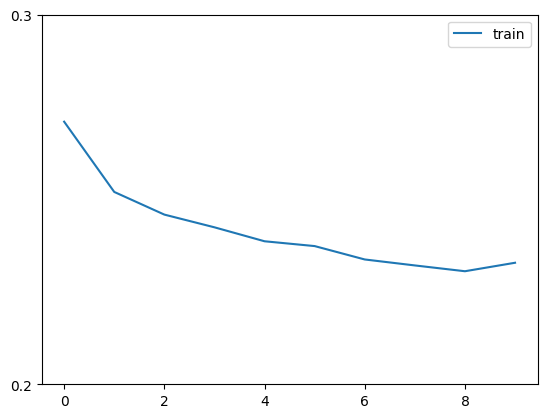

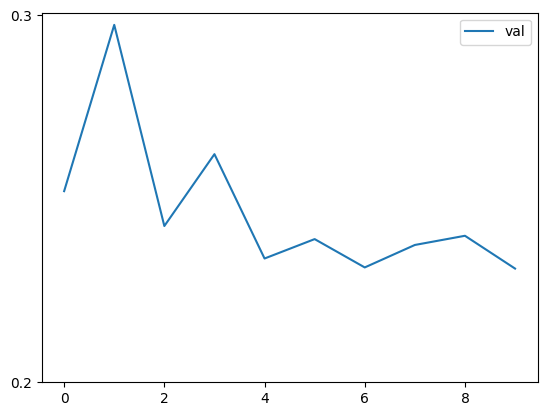

In [64]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
# set y ticks range form 0 to 0.5
plt.yticks(np.arange(0.2, 0.4, 0.1))
plt.legend()
plt.show()

plt.plot(val_losses, label='val')
# set y ticks range form 0 to 0.5
plt.yticks(np.arange(0.2, 0.4, 0.1))
plt.legend()
plt.show()

In [65]:
macro_f1 = 0 
weighted_f1  = 0 

In [66]:
import torch
from sklearn.metrics import f1_score, confusion_matrix

def calculate_f1_score(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            speakers = batch['speakers']
            sentence_encoding = batch['sentence_encoding'].to(device)
            logits = model(input_ids, attention_mask, speakers, sentence_encoding)
            predicted = torch.argmax(logits, dim=1).cpu().numpy()
            true_labels = labels.cpu().numpy()
            all_preds.extend(predicted)
            all_labels.extend(true_labels[0])

            
    labels = [0, 1, 2]
    label_wise_f1 = f1_score(all_labels, all_preds, labels=labels, average=None)
    
    # Print label-wise F1 scores
    for label, f1 in zip(labels, label_wise_f1):
        print(f"F1 Score for class {label}: {f1:.4f}")
    
    # Calculate and plot the confusion matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(all_labels, all_preds, labels=labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # print overall F1
    print(f"Overall F1 Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")
    # precision recall 
    print("WEIGHTED")
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, fscore, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {fscore:.4f}")

    global weighted_f1

    weighted_f1 = fscore 

    

F1 Score for class 0: 0.9472
F1 Score for class 1: 0.3699
F1 Score for class 2: 0.5563


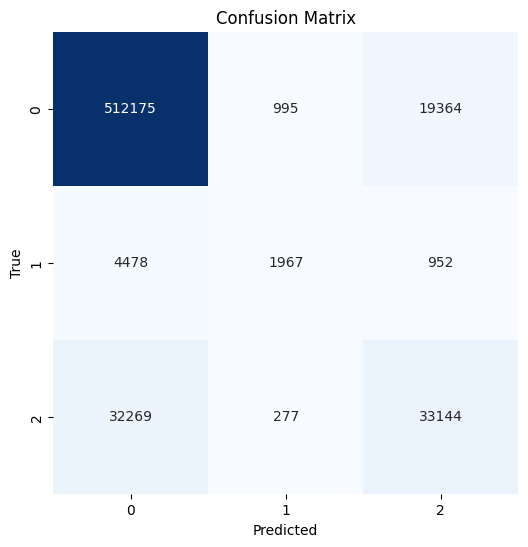

Overall F1 Score: 0.8977
Precision: 0.8951, Recall: 0.9037, F1 Score: 0.8977


In [67]:
state_dict = torch.load("model_project210.pt")
model.load_state_dict(state_dict)
model.to(DEVICE)

train_loader = DataLoader(CPI_Dataset("train_file.json"), batch_size=1, shuffle=True)
calculate_f1_score(model, train_loader, DEVICE)


F1 Score for class 0: 0.9469
F1 Score for class 1: 0.3321
F1 Score for class 2: 0.5072


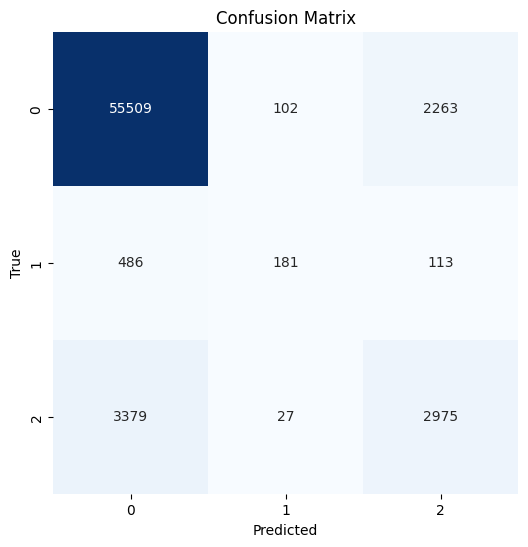

Overall F1 Score: 0.8963
Precision: 0.8935, Recall: 0.9021, F1 Score: 0.8963


In [68]:
state_dict = torch.load('model_project210.pt')
model.load_state_dict(state_dict)
val_loader = DataLoader(CPI_Dataset("val_file.json"), batch_size=1, shuffle=True)
model = model.to(DEVICE)
calculate_f1_score(model, val_loader, DEVICE)